# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [165]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
validation_file='valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import numpy as np

# TODO: Number of training examples
n_train = np.size(X_train, axis=0)

# TODO: Number of validation examples
n_validation = np.size(X_valid, axis=0)

# TODO: Number of testing examples.
n_test = np.size(X_test, axis=0)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_train).size

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

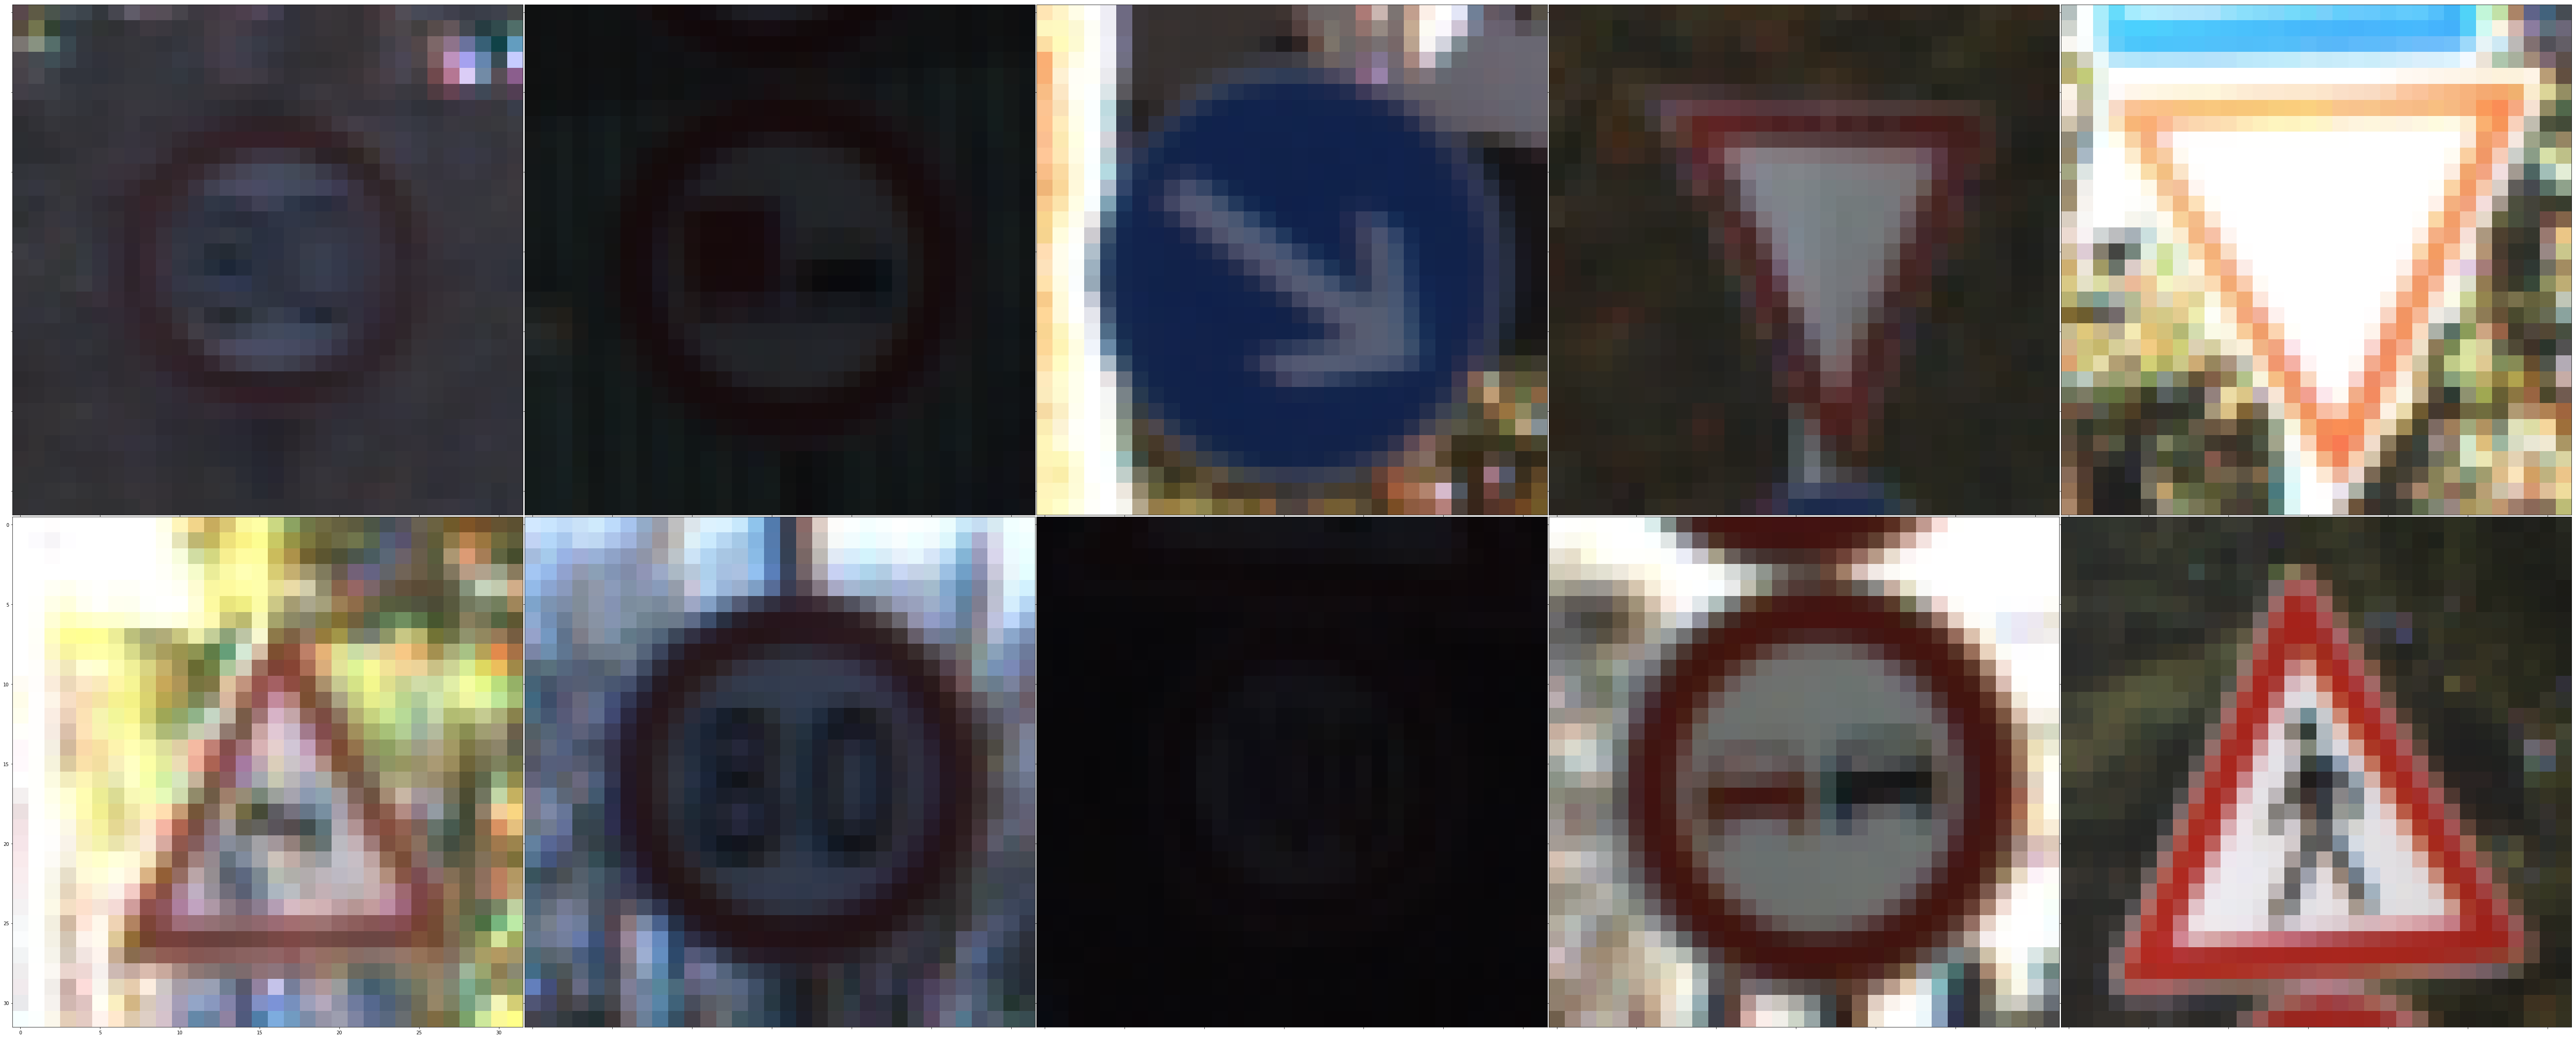

In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

# Visualizations will be shown in the notebook.
%matplotlib inline
grid = AxesGrid(plt.figure(figsize=(100,100)), 111,
                    nrows_ncols=(2, 5),
                    axes_pad=0.05,
                    label_mode="1")

# show 10 random images
for i in range(10):
    idx = np.random.randint(0, n_train - 1, 1)
    im = grid[i].imshow(X_train[np.asscalar(idx)])

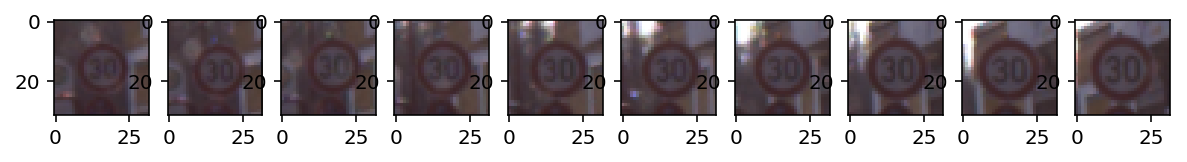

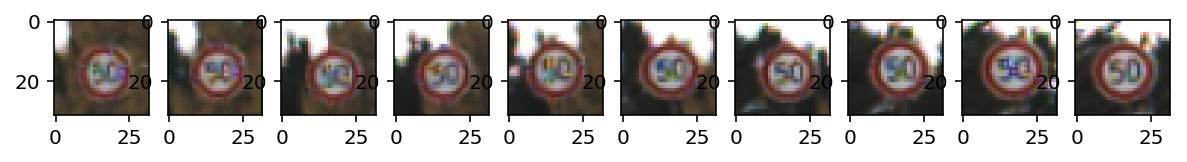

In [174]:
def print_classid(classids, n):
    i = 1
    plt.figure(figsize=(n,1))
    for img,lbl in zip(X_train, y_train):
        if i > n:
            break;
        if lbl in classids:
            plt.subplot(1,n,i)
            plt.imshow(img)
            i = i + 1
            

print_classid([1],10)
print_classid([2],10)

In [4]:
# histogram of classes
from pandas import Series, DataFrame
from collections import Counter
from pandas.io.parsers import read_csv
class_names = read_csv("signnames.csv").values
mapping = dict(zip(class_names[:,0], range(len(class_names))))

"""Get the class name of the image given the class id

Keyword arguments:
class_id -- Class ID to get the name for
"""
def get_class_name(class_id):
    row_idx = mapping[class_id]
    return  class_names[row_idx][1]

"""Returns a histogram distribution of class labels in the data

Keyword arguments:
data - The data
"""
def get_dist_dataframe(train_data, validation_data, test_data):
    
    
    train_class_names = [get_class_name(cid) for cid in train_data]
    validation_class_names = [get_class_name(cid) for cid in validation_data]
    test_class_names = [get_class_name(cid) for cid in test_data]
    
    hist_data = {
        'train': Series(Counter(train_class_names)),
        'test': Series(Counter(test_class_names)),
        'validation': Series(Counter(validation_class_names))
    }

    df = DataFrame(hist_data)
    return df

"""Plots a histogram of the training/test/validation data sets

Keyword arguments:
sub_plots -- Whether to plot each data set in a separate plot or not
"""
def plot_histogram(sub_plots):
    df = get_dist_dataframe(y_train, y_valid, y_test)
    df.plot(kind='bar', figsize=(15,10), subplots=sub_plots)
    print (df)
        

                                                    test  train  validation
Ahead only                                           390   1080         120
Beware of ice/snow                                   150    390          60
Bicycles crossing                                     90    240          30
Bumpy road                                           120    330          60
Children crossing                                    150    480          60
Dangerous curve to the left                           60    180          30
Dangerous curve to the right                          90    300          60
Double curve                                          90    270          60
End of all speed and passing limits                   60    210          30
End of no passing                                     60    210          30
End of no passing by vehicles over 3.5 metric tons    90    210          30
End of speed limit (80km/h)                          150    360          60
General caut

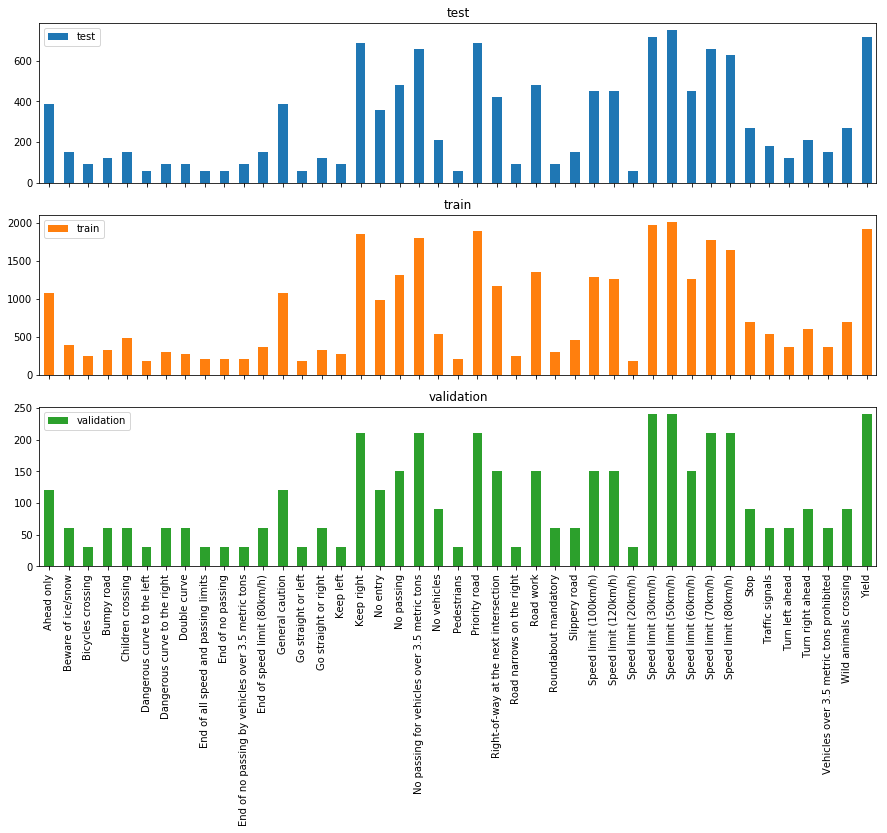

In [5]:
plot_histogram(sub_plots=True)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [118]:
import cv2
from sklearn import preprocessing
from scipy.ndimage import rotate, gaussian_filter
import tensorflow as tf

"""Augment the given image set by adding additional entries and converting to YUV

Keyword arguments:
images -- Image set to augment
labels -- Labels of the image set if available. (For training and validation sets)
rotations -- Rotations to apply to generate new images (For training set)
blur -- Add blurred images to the image set (For training set)
"""
def augment_images(images, labels=np.empty(shape=(0,0)), rotations=[0], blur=False):
    
    # factor by which the output size will increase
    factor = len(rotations)
    if blur:
        factor *= 2 # we will add blurred images
        
    image_shape = list(images.shape)
    
    # if labels are not available, initialize them to -1. These will be ignored
    labels_available = labels.size > 0
    if labels_available == False:
        labels = np.empty(image_shape[0])
        labels.fill(-1) 
    
    # increase the output image set size by the computed factor
    image_shape[0] = image_shape[0] * factor

    augmented_list = np.empty(image_shape)
    augmented_labels = np.empty(image_shape[0])
    
    # clear labels if labels werent passed in
    if labels_available == False:
        augmented_labels = np.empty(shape=(0,0))
    
    j = 0
    for orig_img, label in zip(images, labels):
        images_in = [orig_img]
        if blur:
            blurred_img = gaussian_filter(orig_img, sigma=3)
            images_in.append(blurred_img)
        
        for img in images_in:
            # rotated images
            for deg in rotations:
                rotated_img = rotate(np.copy(img), deg, reshape=False)
                # convert to YUV
                rotated_img = cv2.cvtColor(rotated_img, cv2.COLOR_RGB2YUV)
                augmented_list[j] = rotated_img
                
                # record the image label if available
                if augmented_labels.size > 0:
                    augmented_labels[j] = label
                    
                j+= 1
     
    return (augmented_list, augmented_labels)

"""Preprocess the data through statistical mutations.
The data is zero centered and standard-deviation normalized
"""
def preprocess_data(data):
    # mean subtraction to center around origin
    data -= data_mean
    # normalization
    data /= data_stddev

In [ ]:
X_train, y_train = augment_images(X_train, y_train, rotations=[-10,0,10], blur=True)
X_valid, y_valid = augment_images(X_valid, y_valid) # convert to YUV
X_test, y_test = augment_images(X_test, y_test) # convert to YUV

# update training data set size
image_shape = X_train[0].shape

# compute training data statistics. They are more accurate in float64
X_train = X_train.astype('float64')
X_valid = X_valid.astype('float64')
data_mean = np.mean(X_train, axis=0)
data_stddev = np.std(X_train, axis=0)

for data_array in [X_train, X_valid, X_test]:
    preprocess_data(data_array)

### Model Architecture

In [9]:
import math

"""Creates a convolution layer for the given parameters and 
returns  the output feature maps of the convolution

Keyword arguments:
X -- input data
f -- Filter size (width and height)
c_in -- Input channels
k -- Filter depth
stride -- Stride to use in the convolution algorithm
padding -- Padding algorithm to use (SAME/VALID)
name -- Name of the convolution layer
scope -- Variable scope/namespace
"""
def conv_layer(X, f, c_in, k, stride, padding, name, scope):
    conv = tf.contrib.layers.conv2d(inputs=X, kernel_size=f, stride=stride, padding=padding, num_outputs=k, scope=scope)
    print (conv.get_shape())
    return conv

"""Creates a max pooling layer for the given parameters and 
returns the output feature maps of max pooling

Keyword arguments:
X -- input data
f -- Filter size (width and height)
scope -- Variable scope/namespace
"""
def max_pool(X, f, scope):
    mp = tf.contrib.layers.max_pool2d(inputs=X, kernel_size=f, stride=f, padding='VALID', scope=scope)
    print (mp.get_shape())
    return mp

"""Creates a fully connected layer without non-linear activation
Keyword arguments:
X -- the input to the fully connected layer
f_out -- Number of output features desired
reg -- Regularization strength
name -- Name of the fully connected layer
scope -- Variable scope/namespace
"""
def fc_layer_no_activation(X, f_out, reg, name, scope):
    fc = tf.contrib.layers.fully_connected(
        inputs=X, num_outputs=f_out, weights_regularizer = tf.contrib.layers.l2_regularizer(scale=reg), 
        activation_fn=None, scope=scope)
    print (fc.get_shape())
    return fc
    
"""Creates a fully connected layer with ReLu activation

Keyword arguments:
X -- the input to the fully connected layer
f_out -- Number of output features desired
reg -- Regularization strength
is_training -- Whether this is the training phase or not
name -- Name of the fully connected layer
scope -- Variable scope/namespace
"""
def fc_layer(X, f_out, reg, is_training, name, scope):
    # use Relu activated FC
    fc = fc_layer_no_activation(X, f_out, reg, name, scope)  
    fc = tf.contrib.layers.batch_norm(fc, center=True, scale=True, is_training=is_training, scope=scope)
    # pass through a ReLU
    fc = tf.nn.relu(fc, name=name)
    
    return fc

In [10]:
"""Get the logits from the Conv Net

Keyword arguments:
X -- The data set
is_training -- Whether we are training the Conv Net or not
reg -- L2 regularization strength
keep_prob -- Dropout (keep) probability
"""
def GetLogits(X, is_training, reg, keep_prob=1.0):
    in_channels = image_shape[2]
    p ='VALID'
    s = 1
    f = 3

    k1 = 6
    conv1 = conv_layer(X, f=f, c_in=in_channels, k=k1, stride=s, padding=p, name='Conv_Layer_1', scope='conv1')

    k2 = 16
    conv2 = conv_layer(conv1, f=f, c_in=k1, k=k2, stride=s, padding=p, name='Conv_Layer_2', scope='conv2')

    maxpool_f = 2
    maxpool1 = max_pool(conv2, maxpool_f, scope='mp1')

    k3 = 24
    conv3 = conv_layer(maxpool1, f=f, c_in=k2, k=k3, stride=s, padding=p, name='Conv_Layer_3', scope='conv3')

    k4 = 36
    conv4 = conv_layer(conv3, f=f, c_in=k3, k=k4, stride=s, padding=p, name='Conv_Layer_4', scope='conv4')
    
    # maxpool
    maxpool2 = max_pool(conv4, maxpool_f, scope='mp2')
    
    k5 = 48
    conv5 = conv_layer(maxpool2, f=f, c_in=k4, k=k5, stride=s, padding=p, name='Conv_Layer_5', scope='conv5')

    # flatten the convoluted input
    fc_input = tf.contrib.layers.flatten(conv5)
    
    # connected layer
    n_features = fc_input.get_shape()[1].value
    print ("Number of features: {}".format(n_features))
    n_hidden_1 = 120
    fc1 = fc_layer(fc_input, n_hidden_1, reg, is_training, name='FC1', scope='fc1')
    # drop out
    fc2 = tf.nn.dropout(fc1, keep_prob)

    n_hidden_2 = 84
    fc2 = fc_layer(fc1, n_hidden_2, reg, is_training, name='FC2', scope='fc2')
    # dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # logits
    logits = fc_layer_no_activation(
        fc2, n_classes, reg, name='Logits_Layer', scope='logits')

    # return the logits
    return logits
    
    

### Train, Validate and Test the Model


A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [63]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, (None, image_shape[0], image_shape[1], image_shape[2]), name='x_placeholder')
y = tf.placeholder(tf.int32, (None), name='y_placeholder')
is_training = tf.placeholder(tf.bool)
keep_prob = tf.placeholder(tf.float32, name='keep_prob')
top_n = tf.placeholder(tf.int32, name='top_n')

onehot_y = tf.one_hot(y, n_classes)
batch_size = 256 # use power of 2 for GPU optimization
epochs = 20
reg = 0.5 # regularization strength lambda

In [64]:
Learn_Rate = 0.0002
logits = GetLogits(x, is_training, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=onehot_y)
reg_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss_operation = tf.reduce_mean(cross_entropy) + tf.reduce_mean(reg_loss)

# when training, the moving_mean and moving_variance need to be updated. 
# By default the update ops are placed in tf.GraphKeys.UPDATE_OPS, 
#so they need to be added as a dependency to the train_op.
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):    
    trainer = tf.train.AdamOptimizer(learning_rate = Learn_Rate).minimize(loss_operation)

(?, 30, 30, 6)
(?, 28, 28, 16)
(?, 14, 14, 16)
(?, 12, 12, 24)
(?, 10, 10, 36)
(?, 5, 5, 36)
(?, 3, 3, 48)
Number of features: 432
(?, 120)
(?, 84)
(?, 43)


In [65]:
# TensorFlow session operations

# get softmax probabilities of the scores
softmax_probs = tf.nn.softmax(logits)
# top N softmax probabilites
top_n_softmax = tf.nn.top_k(softmax_probs, k=top_n)
# get the class predictions from the logits
class_predicted = tf.argmax(logits, 1)
# get the actual class from the labels
actual_class = tf.argmax(onehot_y,1)
# Check for correct model predictions
correct_prediction = tf.equal(class_predicted, actual_class)
# Measure accuracy as the average number of correct predictions
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


"""Evaluate the Conv Net model

Keyword arguments:
x_set -- Data set to evaluate against
y_set -- Labels of the data set
"""
def evaluate(x_set, y_set):
    sess = tf.get_default_session()
    
    num_examples = len(x_set)
    num_correct_preds = 0.0
    total_loss=0.0
    for i in range(0, num_examples, batch_size):
        start_idx = i
        end_idx = i + batch_size
        x_batch = x_set[start_idx:end_idx]
        y_batch = y_set[start_idx:end_idx]
        loss, accuracy = sess.run([loss_operation, accuracy_operation], 
                                  feed_dict= {x: x_batch, y:y_batch, is_training: False, keep_prob: 1.0})
        num_correct_preds += (len(x_batch) * accuracy)
        total_loss += (loss * len(x_batch))
    return total_loss/num_examples, num_correct_preds/num_examples

Starting training
Number of examples: 208794
Epoch 1 ...
Epoch: 1: Training Loss: 6.244
Epoch: 1: Training Accuracy: 0.067
Epoch: 1: Validation Loss: 6.257
Epoch: 1: Validation Accuracy: 0.071
Epoch 2 ...
Epoch: 2: Training Loss: 4.914
Epoch: 2: Training Accuracy: 0.075
Epoch: 2: Validation Loss: 4.927
Epoch: 2: Validation Accuracy: 0.082
Epoch 3 ...
Epoch: 3: Training Loss: 4.740
Epoch: 3: Training Accuracy: 0.070
Epoch: 3: Validation Loss: 4.752
Epoch: 3: Validation Accuracy: 0.076
Epoch 4 ...
Epoch: 4: Training Loss: 4.469
Epoch: 4: Training Accuracy: 0.150
Epoch: 4: Validation Loss: 4.474
Epoch: 4: Validation Accuracy: 0.176
Epoch 5 ...
Epoch: 5: Training Loss: 3.994
Epoch: 5: Training Accuracy: 0.415
Epoch: 5: Validation Loss: 3.984
Epoch: 5: Validation Accuracy: 0.452
Epoch 6 ...
Epoch: 6: Training Loss: 3.202
Epoch: 6: Training Accuracy: 0.793
Epoch: 6: Validation Loss: 3.164
Epoch: 6: Validation Accuracy: 0.830
Epoch 7 ...
Epoch: 7: Training Loss: 2.383
Epoch: 7: Training Accur

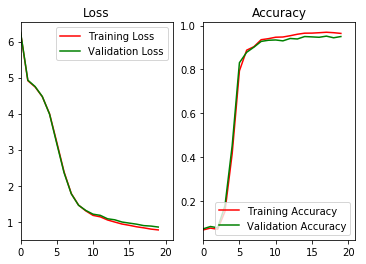

In [66]:
### Train your model here.
from sklearn.utils import shuffle

num_examples = len(X_train)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print("Starting training")
    print ("Number of examples: {}".format(num_examples))

    training_losses = []
    validation_losses = []
    training_accuracies = []
    validation_accuracies = []
    for j in range(epochs):
        print ("Epoch {} ...".format(j+1))
        X_train, y_train = shuffle(X_train, y_train)

        for i in range(0, num_examples, batch_size):
            start_idx = i
            end_idx = i + batch_size
            x_batch = X_train[start_idx:end_idx]
            y_batch = y_train[start_idx:end_idx]
            sess.run(trainer, feed_dict= {x: x_batch, y: y_batch, is_training: True, keep_prob: 0.5})

        training_loss, training_accuracy = evaluate(X_train, y_train)
        print ("Epoch: {}: Training Loss: {:.3f}".format(j+1, training_loss))
        print ("Epoch: {}: Training Accuracy: {:.3f}".format(j+1, training_accuracy))
        training_losses.append(training_loss)
        training_accuracies.append(training_accuracy)

        validation_loss, validation_accuracy = evaluate(X_valid, y_valid)
        print ("Epoch: {}: Validation Loss: {:.3f}".format(j+1, validation_loss))  
        print ("Epoch: {}: Validation Accuracy: {:.3f}".format(j+1, validation_accuracy))
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)

    plt.figure(1)
    loss_plot = plt.subplot(1,2,1)
    loss_plot.set_title('Loss')
    loss_plot.plot(training_losses, 'r', label='Training Loss')
    loss_plot.plot(validation_losses, 'g', label='Validation Loss')
    loss_plot.set_xlim([0, epochs+1])
    loss_plot.legend(loc=1)

    acc_plot = plt.subplot(1,2,2)
    acc_plot.set_title('Accuracy')
    acc_plot.plot(training_accuracies, 'r', label='Training Accuracy')
    acc_plot.plot(validation_accuracies, 'g', label='Validation Accuracy')
    acc_plot.set_xlim([0, epochs+1])
    acc_plot.legend(loc=4)
    
    saver = tf.train.Saver()
    saver.save(sess, './traffic_net.ckpt')
    print ("Model Saved")
    

    
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

In [114]:
# Test accuracy
def test_accuracy(x_set, y_set):
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, './traffic_net.ckpt')
        
        test_loss, test_accuracy = evaluate(x_set, y_set)
        print ("Test Loss: {:.3f}".format(test_loss))  
        print ("Test Accuracy: {:.3f}".format(test_accuracy))
    

"""Get the predictions for the given data set from the CONV Net model

Keyword arguments:
x_set -- Data set to get predictions for
"""
def get_predictions(x_set): 
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, './traffic_net.ckpt')
        
        actual= sess.run([class_predicted], 
                            feed_dict= {x: x_set, is_training: False, keep_prob: 1.0})

        return actual[0]
    

"""Get top-N softmax probabilities for the given data set

Keyword arguments:
x_set - the data set
n - Number of probabilities to return
"""
def get_softmax_probabilities(x_set, n):
    saver = tf.train.Saver()
    with tf.Session() as sess:
        saver.restore(sess, './traffic_net.ckpt')
    
        probs = sess.run([top_n_softmax],
                            feed_dict= {x: x_set, top_n: n, is_training: False, keep_prob: 1.0})

        return probs

In [68]:
test_accuracy(X_test, y_test)

Test Loss: 0.899
Test Accuracy: 0.932


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

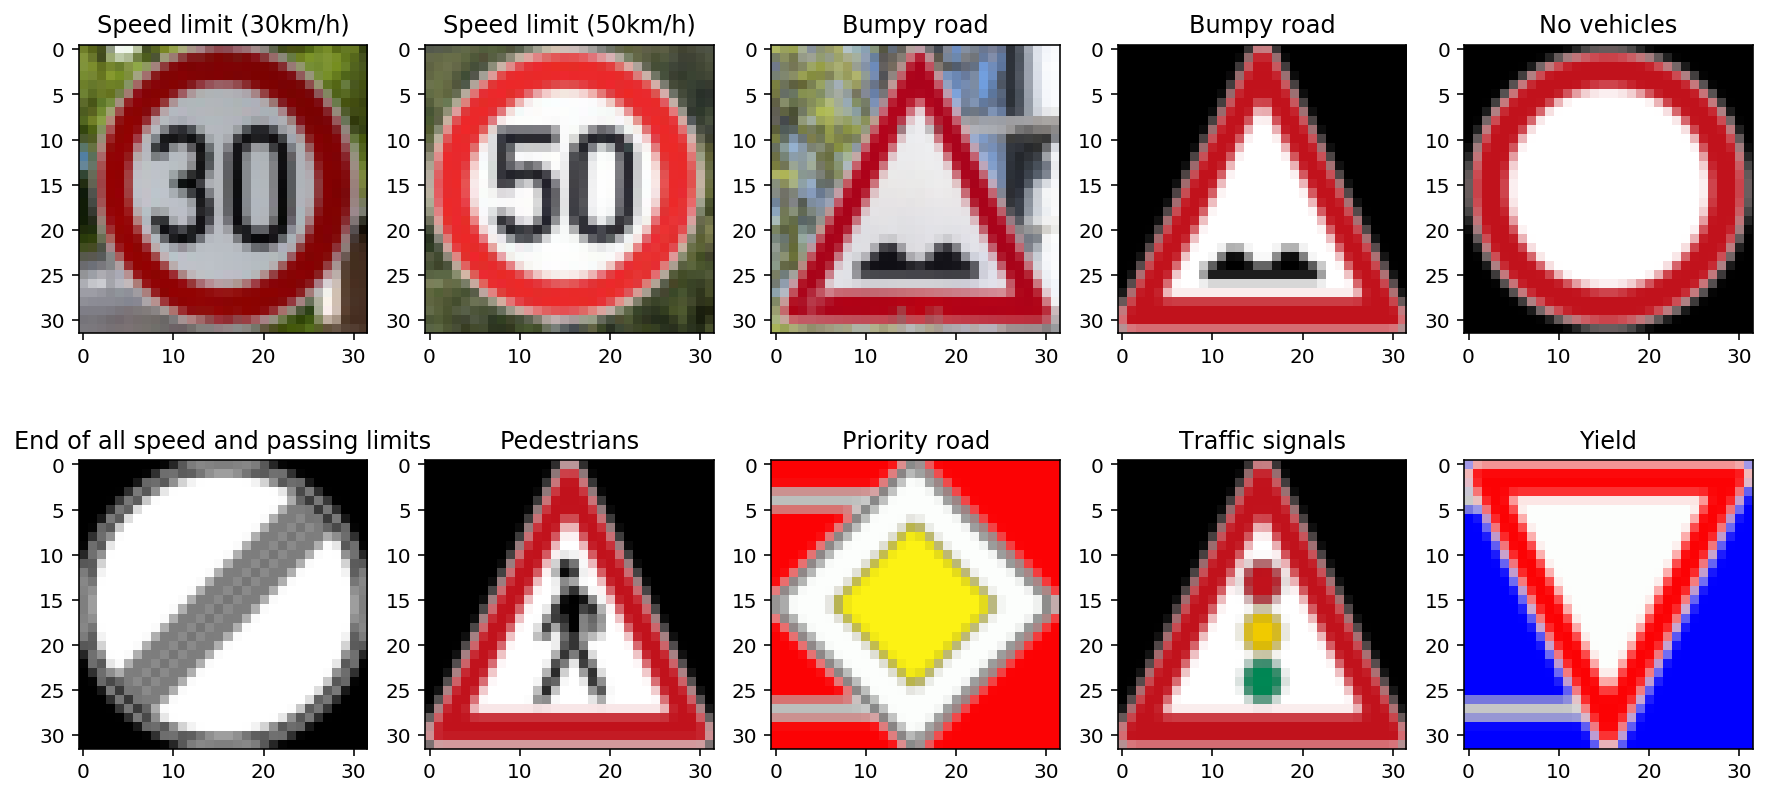

In [156]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
from os import listdir, getcwd
from os.path import isfile
from scipy.misc import imread, imresize

cwd = getcwd()
file_path='/'.join([cwd, 'Test_Photos'])
files = [f for f in listdir(file_path) if isfile('/'.join([file_path, f]))]
files.sort()
new_image_labels = [1,2,22,22,15,32,27,12,26,13]

plt.figure(figsize=(15,7))
n_cols = len(files)
target_dim = 32
i = 1
new_images = []
for f, label in zip(files, new_image_labels):
    class_name = get_class_name(label)
    img = imread('/'.join([file_path, f]), mode='RGB')
    img = imresize(img, (target_dim, target_dim))
    img_plot = plt.subplot(2, n_cols/2, i)
    img_plot.set_title(class_name)
    plt.imshow(img)
    new_images.append(img)
    
    i+= 1
                      
plt.show()

In [157]:
# preprocess the loaded images
def preprocess_images_to_predict(images):
    images, no_labels = augment_images(images)
    assert(no_labels.size == 0)
    # apply the statistical preprocessing from training
    preprocess_data(images)
    return images

new_images = np.array(new_images)
x_yuv = np.copy(new_images)
x_yuv = preprocess_images_to_predict(x_yuv)

### Predict the Sign Type for Each Image

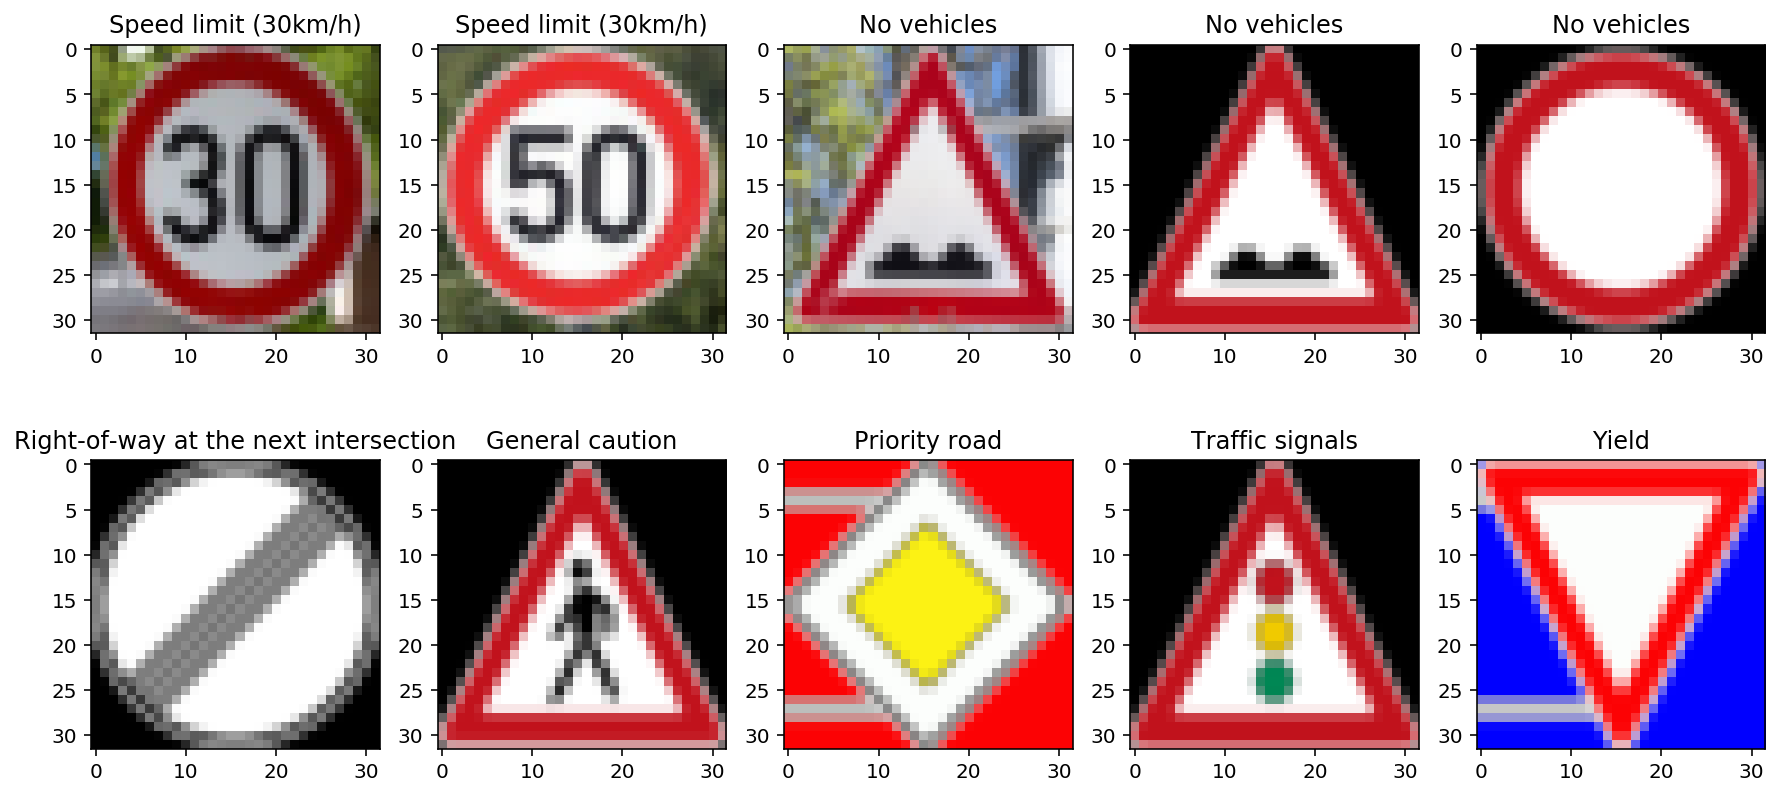

In [158]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
%config InlineBackend.figure_format='retina'
fig = plt.figure(figsize=(15,7))
img_classes = get_predictions(x_yuv)

i= 0
num_plots = len(img_classes)
for img, img_class in zip(new_images, img_classes):
    # look up the class name
    class_name = get_class_name(img_class)
    img_plot = plt.subplot(2, num_plots/2, i+1)
    img_plot.set_title(class_name)
    plt.imshow(img)
    i+= 1

### Analyze Performance

In [159]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
test_accuracy(x_yuv, new_image_labels)

Test Loss: 1.526
Test Accuracy: 0.500


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [161]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
probs = get_softmax_probabilities(x_yuv, 5)
print (probs)

[TopKV2(values=array([[  9.75198746e-01,   3.83435888e-03,   2.03148671e-03,
          1.67387759e-03,   1.24791381e-03],
       [  5.68476200e-01,   3.12306374e-01,   1.40171051e-02,
          9.60599072e-03,   9.21471138e-03],
       [  5.75826406e-01,   3.03064972e-01,   4.82136719e-02,
          9.77002177e-03,   6.67149667e-03],
       [  7.60132015e-01,   1.89945757e-01,   1.89040639e-02,
          6.06755540e-03,   3.83109902e-03],
       [  8.38208199e-01,   1.00188009e-01,   8.26622825e-03,
          8.07582308e-03,   7.94437062e-03],
       [  2.12310091e-01,   8.35739076e-02,   8.04465711e-02,
          5.25692813e-02,   4.50163260e-02],
       [  4.44556803e-01,   1.96835741e-01,   1.67832226e-01,
          2.48620510e-02,   2.29803436e-02],
       [  9.94286478e-01,   5.25176525e-04,   5.00071561e-04,
          3.46895948e-04,   3.46674991e-04],
       [  8.17274034e-01,   7.81413764e-02,   2.59194970e-02,
          1.75238140e-02,   1.69025417e-02],
       [  5.20480275e-

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")